## Recovering supervised and unsupervised subspaces in simulated data
In this tutorial, we will use simulated data to demonstrate the general utility of the `sispca` package for recovering supervised and unsupervised subspaces. We will also discuss limitations to be aware of when using the package, including the subspace identifiability problem.

In [2]:
import torch
from lightning.pytorch import seed_everything
import numpy as np
import pandas as pd
from scipy.linalg import subspace_angles
from plotnine import *

from sispca import Supervision, SISPCADataset, SISPCA

torch.set_default_dtype(torch.float32)

### Simulate the donut-shaped data
Now let's first create the low-dimensional space (dim = 6) we want to recover. It consists of:

- 'S1': a 2d subspace where points are drawn from two separate Gaussian distributions,
- 'S2': a 2d subspace of a regular grid with some noise,
- 'S3': a 2d subspace of a donut shape with some noise.

To guide subspace recovery, we will provide the cluster identity and the noise-free grid location, such that the learning of the first two subspaces will be considered as "supervised". The last donut subspace will remain hidden from the user and thus be unsupervised.

#### Generate the low-dimensional data

In [3]:
torch.manual_seed(20241011)

n = 2000

# categorical latent variable
y_cat = torch.concat([torch.zeros(int(n/2), 1), torch.ones(int(n/2), 1)]).squeeze()

# continuous latent variable
y_cont = torch.rand(n, 2)
y_cont -= y_cont.mean(axis=0, keepdim=True)

# donut latent variable
y_phi = torch.arange(start = 0, end = torch.pi * 2, step = torch.pi/n * 2)
y_phi = y_phi[torch.randperm(n)]

In [4]:
# the categorical subspace: n x 2
s_cat = torch.concat(
    [
        torch.normal(1, 1, size=(int(n/2), 2)), 
        torch.normal(-1, 1, size=(int(n/2), 2))
    ]
) # n x 2

# the continuous subspace: n x 2
s_cont = y_cont + torch.normal(0, 0.1, size = (n,2)) # n x 2
s_cont = s_cont.float()

# the donut subspace
s_phi = torch.stack(
    [
        torch.cos(y_phi) + torch.normal(0, 0.2, size = (n,)),
        torch.sin(y_phi) + torch.normal(0, 0.2, size = (n,))
    ], axis = 1
) # n x 2

# combine the three subspaces
s_lowd = torch.concat([s_cat, s_cont, s_phi], axis = 1)
s_lowd -= s_lowd.mean(axis=0, keepdims=True)
s_lowd /= s_lowd.var(axis=0, keepdims=True)

Let's visualize the low-dimensional space.

In [5]:
# create
df_anno = pd.DataFrame({
    'cat': pd.Categorical(y_cat.numpy(), categories=[0, 1]),
    'cont': y_cont.sum(1),
    'cont_1': y_cont[:,0],
    'cont_2': y_cont[:,1],
    'phi': y_phi
})

df_lowd = pd.concat([
    pd.DataFrame({
        'cat': pd.Categorical(y_cat.numpy(), categories=[0, 1]),
        'cont': y_cont.sum(1),
        'cont_1': y_cont[:,0],
        'cont_2': y_cont[:,1],
        'phi': y_phi,
        'subspace': _n,
        'dim_1': _s[:,0].numpy(),
        'dim_2': _s[:,1].numpy()
    })
    for _s, _n in zip(
        torch.split(s_lowd, [2, 2, 2], dim = -1),
        ['Categorical', 'Continuous', 'Donut']
    )
])

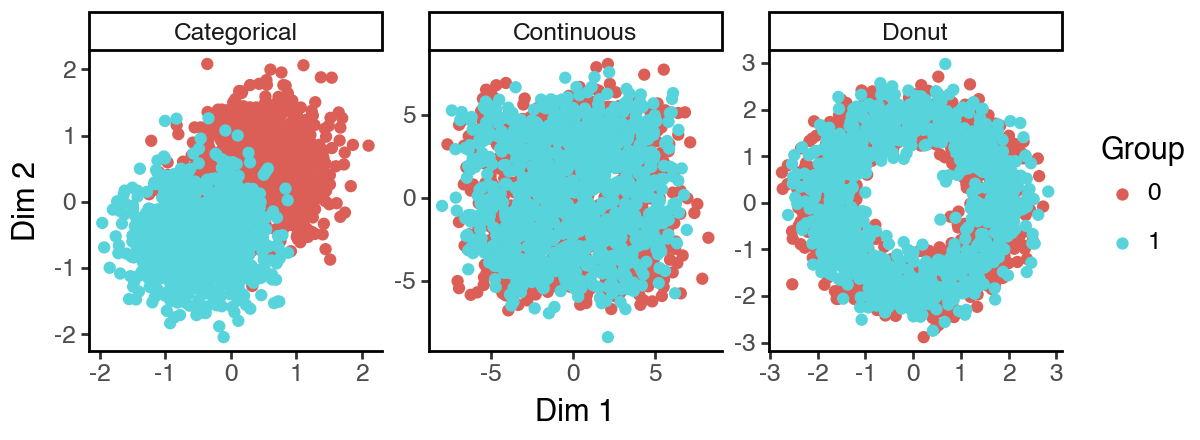

In [6]:
(
    ggplot(df_lowd, aes(x = 'dim_1', y = 'dim_2', color = 'cat')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'Dim 1', y = 'Dim 2', color = 'Group') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

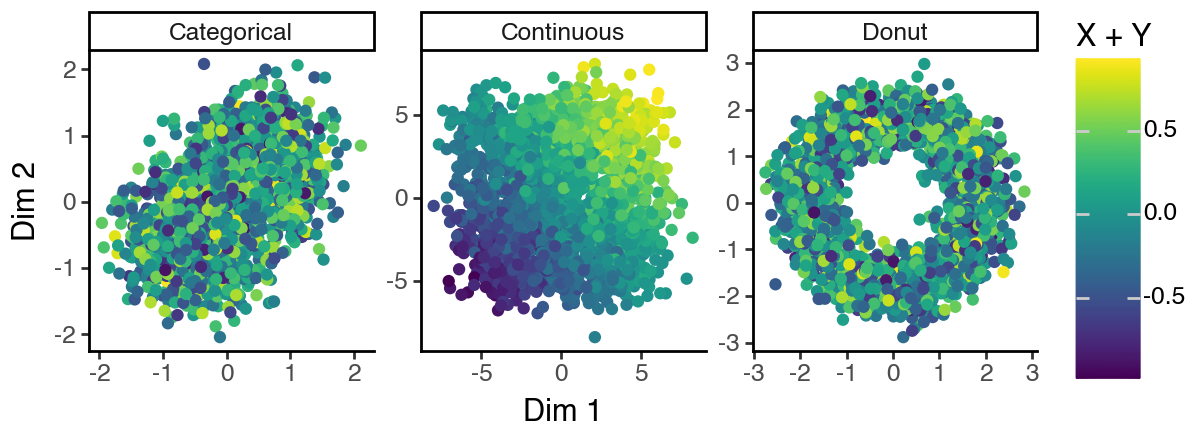

In [7]:
(
    ggplot(df_lowd, aes(x = 'dim_1', y = 'dim_2', color = 'cont')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'Dim 1', y = 'Dim 2', color = 'X + Y') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

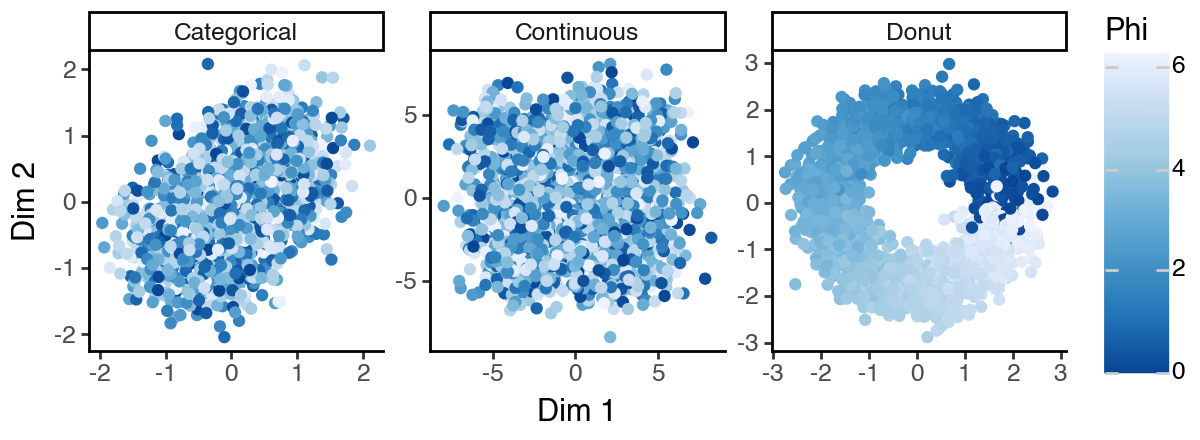

In [8]:
(
    ggplot(df_lowd, aes(x = 'dim_1', y = 'dim_2', color = 'phi')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'Dim 1', y = 'Dim 2', color = 'Phi') +
        scale_color_distiller(palette = 1) + 
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

#### Project to higher dimensions
We will then randomly project the low-dimensional data to a higher-dimensional space (dim = 20) to simulate the high-dimensional data.

In [9]:
M = torch.rand(6, 20)
# # the choice of M does not matter
# M = torch.randn(6, 20)
M /= M.norm(dim=0, keepdim=True)
s_highd = s_lowd @ M

In the simulated data, we can see that the supervised information has been corrupted by noise. Here we measure the principal angles between the supervision and the data. The higher the value (up to pi/2), the harder it will be to recover the corresponding subspace.

In [10]:
print(f"Categorical info vs s_highd: {np.rad2deg(subspace_angles(y_cat[:, None], s_highd.numpy())).max():.2f} degree")
print(f"Continuous info vs s_highd: {np.rad2deg(subspace_angles(y_cont, s_highd.numpy())).max():.2f} degree")
print(f"Donut info vs s_highd: {np.rad2deg(subspace_angles(y_phi[:, None], s_highd.numpy())).max():.2f} degree")

Categorical info vs s_highd: 55.03 degree
Continuous info vs s_highd: 19.33 degree
Donut info vs s_highd: 68.00 degree


### Run the PCA and sPCA baselines
Now we can check the performance of PCA and sPCA on the simulated data. Note that PCA will consider all three subspaces as unsupervised and thus generate the same representations, while in [sPCA (Barshan, Elnaz, et al.)](https://www.sciencedirect.com/science/article/pii/S0031320310005819) only the last donut subspace is unsupervised, which will be the PCA solution.  

#### Principal component analysis (PCA)

In [11]:
u, s, _ = torch.pca_lowrank(s_highd, q=6, center = True)
pca_rep = u @ torch.diag(s)

In [12]:
df_pca = pd.concat([
    pd.DataFrame({
        'cat': pd.Categorical(y_cat.numpy(), categories=[0, 1]),
        'cont': y_cont.sum(1),
        'cont_1': y_cont[:,0],
        'cont_2': y_cont[:,1],
        'phi': y_phi,
        'subspace': _n,
        'dim_1': pca_rep[:,0].numpy(),
        'dim_2': pca_rep[:,1].numpy()
    })
    for _n in ['Categorical', 'Continuous', 'Donut']
])


As can be seen below, the PCA space mostly captures the 'S2: Continuous' subspace since it appears to have the highest variance.

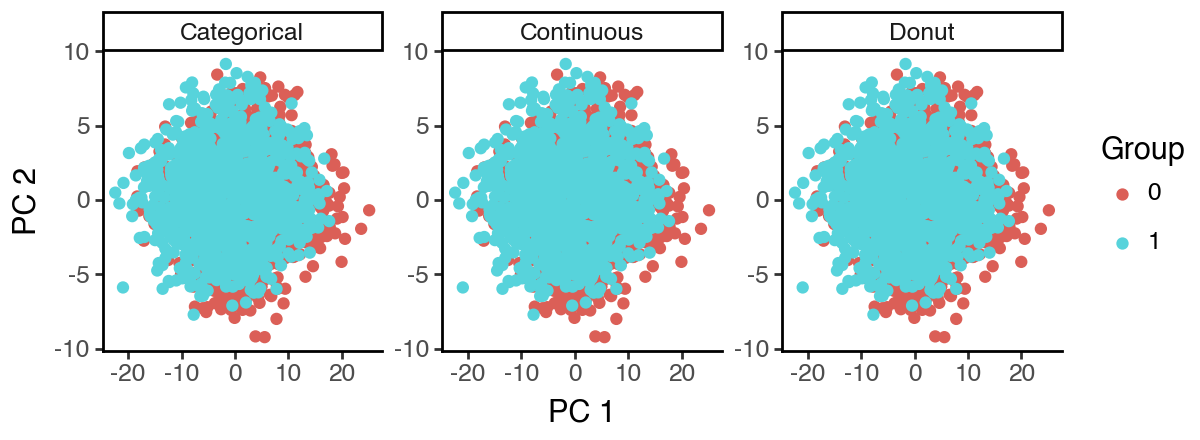

In [13]:
(
    ggplot(df_pca, aes(x = 'dim_1', y = 'dim_2', color = 'cat')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Group') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

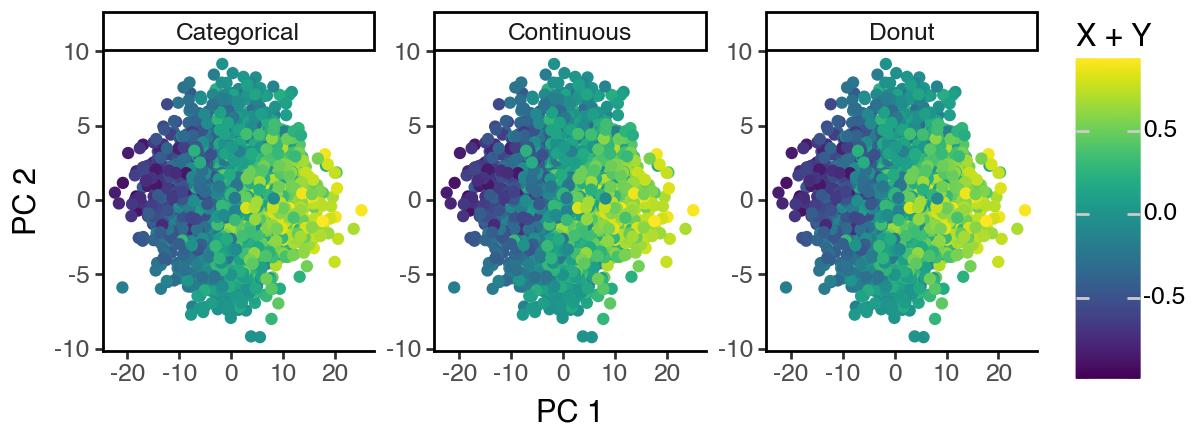

In [14]:
(
    ggplot(df_pca, aes(x = 'dim_1', y = 'dim_2', color = 'cont')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'X + Y') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

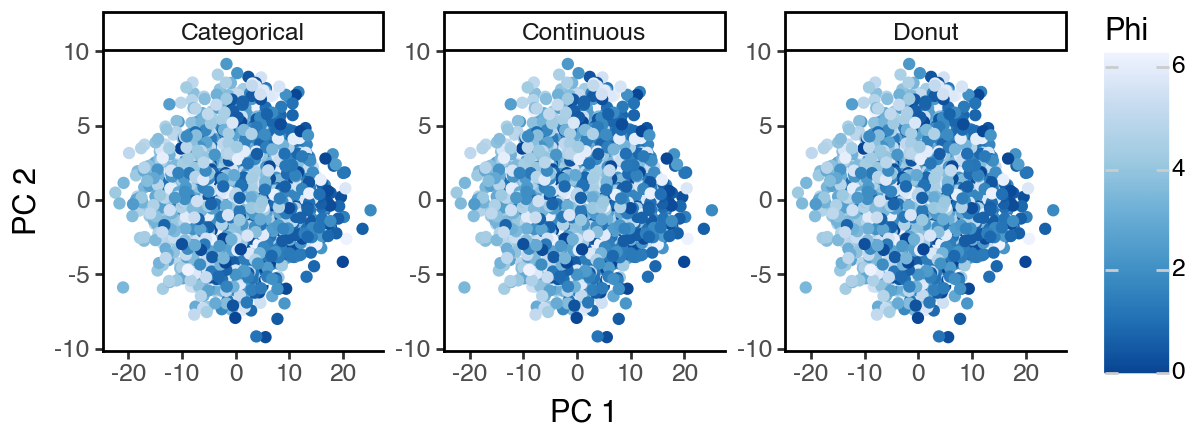

In [15]:
(
    ggplot(df_pca, aes(x = 'dim_1', y = 'dim_2', color = 'phi')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Phi') +
        scale_color_distiller(palette = 1) + 
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

#### Supervised PCA (sPCA)
Now let's run sPCA to try to recover the 'S1: Categorical' and 'S2: Continuous' subspace. Since sPCA do not enforce disentanglement, the 'S3: Donut' subspace is just the unsupervised subspace, which significantly overlaps with 'S2'.

In [16]:
sdata = SISPCADataset(
    data = s_highd.float(),
    target_supervision_list=[
        Supervision(
            target_data=y_cat,
            target_type='categorical',
            target_name='y_cat'
        ),
        Supervision(
            target_data=y_cont,
            target_type='continuous',
            target_name='y_cont'
        ),
    ]
)

In [17]:
n_latent_sub = [2, 2, 2]
lambda_contrast = 0
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

spca = SISPCA(
    sdata, 
    n_latent_sub=n_latent_sub, 
    lambda_contrast=lambda_contrast,
    kernel_subspace=kernel_subspace,
    solver=solver
)
spca.fit(batch_size = -1, max_epochs = 10,early_stopping_patience = 5)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 120    | n/a 
---------------------------------------------
0         Trainable params
120       Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


2 supervision variables provided for 3 subspaces. The last subspace will be unsupervised.


/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [18]:
# extract latent representations
spca_rep = spca.get_latent_representation()

df_spca = pd.concat([
    pd.DataFrame({
        'cat': pd.Categorical(y_cat.numpy(), categories=[0, 1]),
        'cont': y_cont.sum(1),
        'cont_1': y_cont[:,0],
        'cont_2': y_cont[:,1],
        'phi': y_phi,
        'subspace': _n,
        'dim_1': _s[:,0],
        'dim_2': _s[:,1]
    })
    for _s, _n in zip(
        np.split(spca_rep, [2, 4], axis = -1),
        ['Categorical', 'Continuous', 'Donut']
    )
])

However, since the influence/variation from 'S2' in the data is so strong, sPCA cannot recover 'S1' even under supervision. Again, all three sPCA subspaces appear to mainly capture the structure of 'S2'.

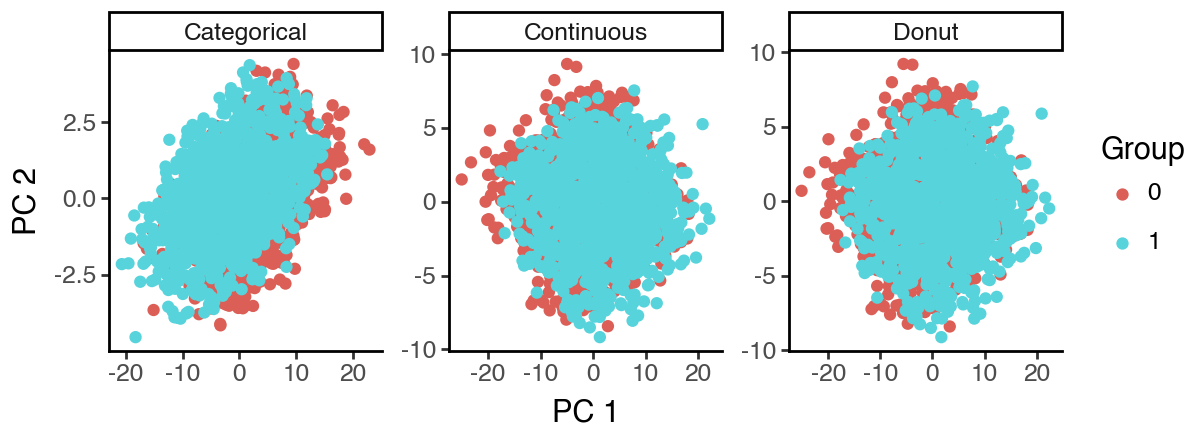

In [19]:
(
    ggplot(df_spca, aes(x = 'dim_1', y = 'dim_2', color = 'cat')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Group') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

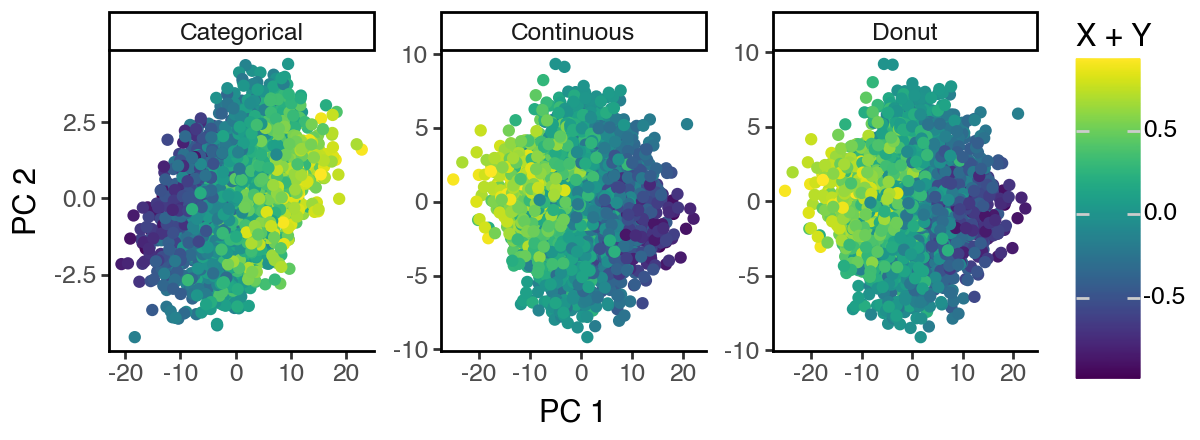

In [20]:
(
    ggplot(df_spca, aes(x = 'dim_1', y = 'dim_2', color = 'cont')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'X + Y') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

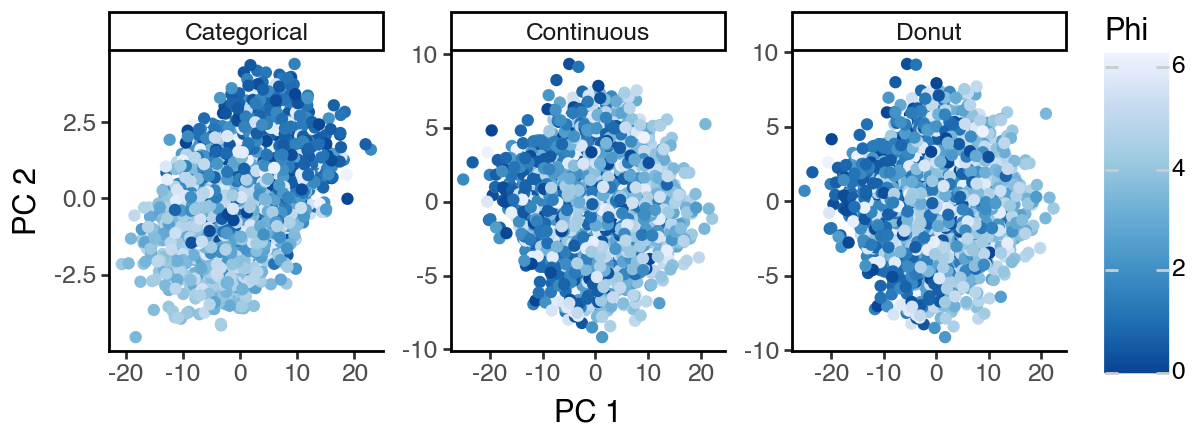

In [21]:
(
    ggplot(df_spca, aes(x = 'dim_1', y = 'dim_2', color = 'phi')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Phi') +
        scale_color_distiller(palette = 1) + 
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

### Supervised independent subspace PCA (sisPCA)
Now let's try enforcing subspace disentanglement with sisPCA. We will use the same supervision as in sPCA to recover the 'S1: Categorical' and 'S2: Continuous' subspaces, and leave 'S3: Donut' as the unsupervised residual subspace.

#### sisPCA-linear (default)
Using HSIC-linear as the independence measure, sisPCA can be solved much more efficiently by iterative eigendecomposition. Although the optimization is non-convex, the linearity still allows for a simpler optimization landscape.

In practice, we always recommend sisPCA-linear (`kernel_subspace = 'linear'`) as the default choice. The sisPCA-general model (`kernel_subspace = 'gaussian'`) is more computationally expensive and less stable, which will be discussed in the next section only as a reference.

In [22]:
sdata = SISPCADataset(
    data = s_highd.float(),
    target_supervision_list=[
        Supervision(
            target_data=y_cat,
            target_type='categorical',
            target_name='y_cat'
        ),
        Supervision(
            target_data=y_cont,
            target_type='continuous',
            target_name='y_cont'
        ),
    ]
)

In [23]:
n_latent_sub = [2, 2, 2]
lambda_contrast = 1
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

sispca = SISPCA(
    sdata, 
    n_latent_sub=n_latent_sub, 
    lambda_contrast=lambda_contrast,
    kernel_subspace=kernel_subspace,
    solver=solver
)
sispca.fit(batch_size = -1, max_epochs = 100, early_stopping_patience = 10)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 120    | n/a 
---------------------------------------------
0         Trainable params
120       Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


2 supervision variables provided for 3 subspaces. The last subspace will be unsupervised.


/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [24]:
# extract latent representations
sispca_rep = sispca.get_latent_representation()

df_sispca = pd.concat([
    pd.DataFrame({
        'cat': pd.Categorical(y_cat.numpy(), categories=[0, 1]),
        'cont': y_cont.sum(1),
        'cont_1': y_cont[:,0],
        'cont_2': y_cont[:,1],
        'phi': y_phi,
        'subspace': _n,
        'dim_1': _s[:,0],
        'dim_2': _s[:,1]
    })
    for _s, _n in zip(
        np.split(sispca_rep, [2, 4], axis = -1),
        ['Categorical', 'Continuous', 'Donut']
    )
])

Now we see that the sisPCA 'S3' subspace successfully recovers the donut shape, while 'S1' and 'S2' also concentrate on their respective supervisions.

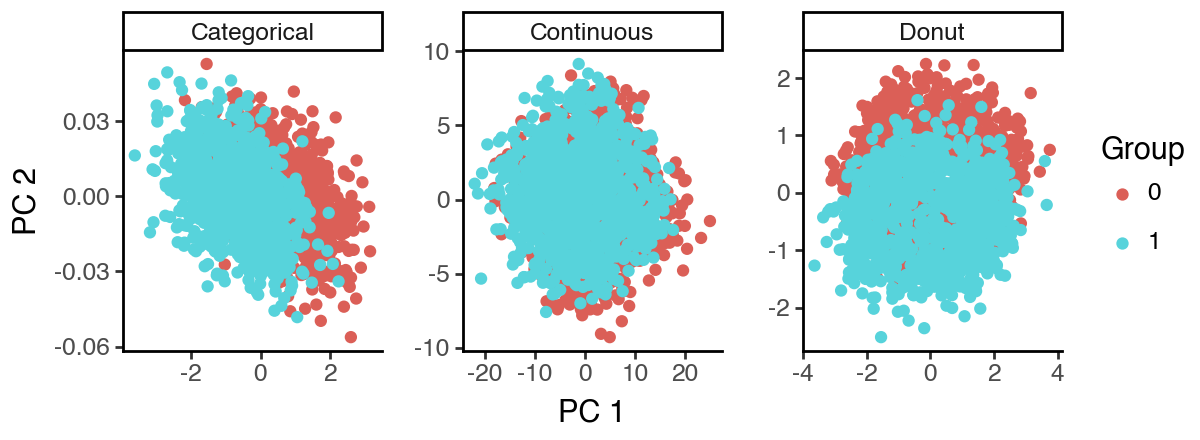

In [25]:
(
    ggplot(df_sispca, aes(x = 'dim_1', y = 'dim_2', color = 'cat')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Group') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

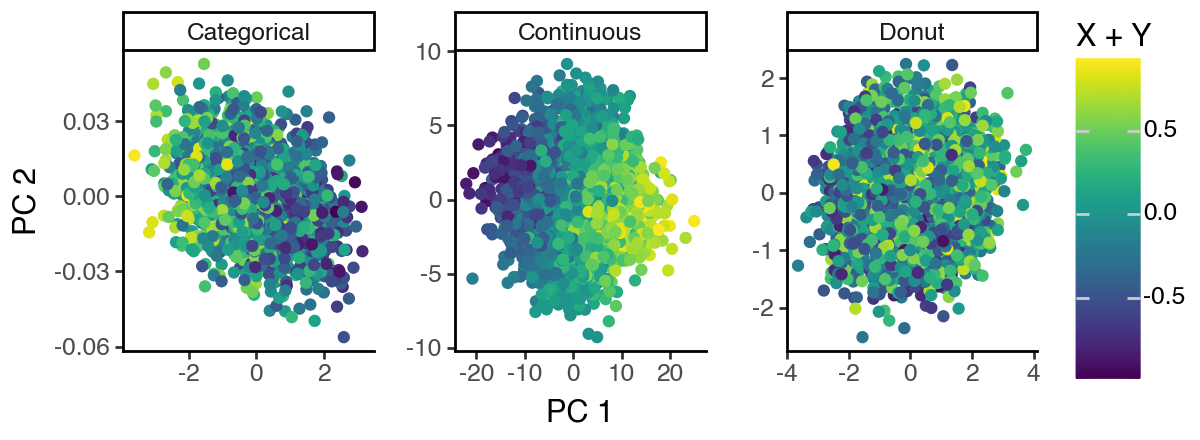

In [26]:
(
    ggplot(df_sispca, aes(x = 'dim_1', y = 'dim_2', color = 'cont')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'X + Y') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

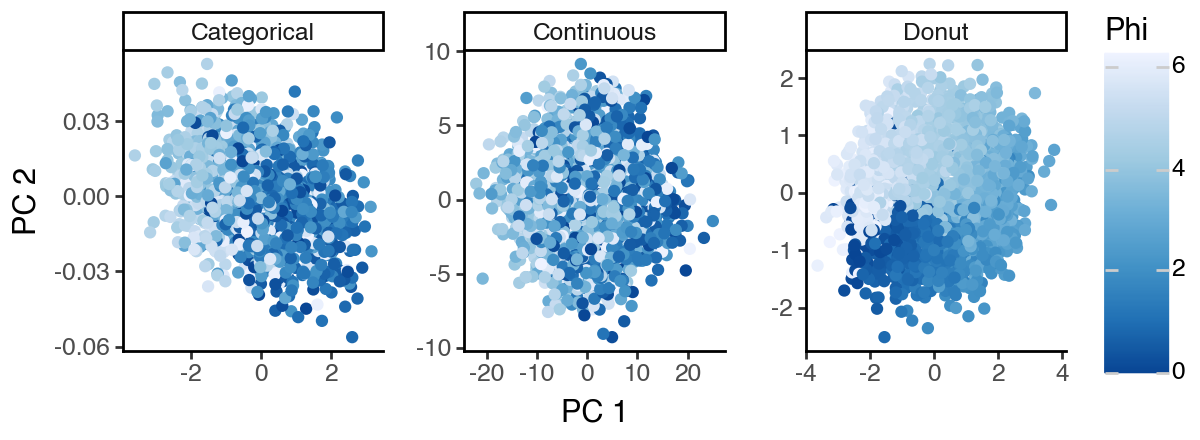

In [27]:
(
    ggplot(df_sispca, aes(x = 'dim_1', y = 'dim_2', color = 'phi')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Phi') +
        scale_color_distiller(palette = 1) + 
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

#### sisPCA-general (not recommended)
For completeness, here we also demonstrate the more general sisPCA model where the subspace disentanglement is enforced through HSIC with a Gaussian kernel. Without linearity, the optimization problem can only be solved by gradient descent, and is more computationally expensive and prone to local minima.

In [28]:
sdata = SISPCADataset(
    data = s_highd.float(),
    target_supervision_list=[
        Supervision(
            target_data=y_cat,
            target_type='categorical',
            target_name='y_cat'
        ),
        Supervision(
            target_data=y_cont,
            target_type='continuous',
            target_name='y_cont'
        ),
    ]
)

n_latent_sub = [2, 2, 2]
lambda_contrast = 1
kernel_subspace = 'gaussian'
solver = 'gd'

seed_everything(42, workers=True)

sispca = SISPCA(
    sdata, 
    n_latent_sub=n_latent_sub, 
    lambda_contrast=lambda_contrast,
    kernel_subspace=kernel_subspace,
    solver=solver
)
sispca.fit(batch_size = -1, max_epochs = 20, early_stopping_patience = None)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 120    | n/a 
---------------------------------------------
120       Trainable params
0         Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


2 supervision variables provided for 3 subspaces. The last subspace will be unsupervised.


/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Note that HSIC-linear and HSIC-gaussian have different scales. Usually HSIC-gaussian will be much smaller, and to achieve better disentalgement, the regularization parameter `lambda_contrast` should be increased.

In [29]:
sispca.history['train_loss_epoch'][-5:], sispca.history['reg_loss_epoch'][-5:]

([-0.2496388703584671,
  -0.2575933039188385,
  -0.24045485258102417,
  -0.2639774978160858,
  -0.26158735156059265],
 [0.04235150292515755,
  0.041558653116226196,
  0.06274184584617615,
  0.03458384424448013,
  0.04475126042962074])

In [30]:
# extract latent representations
sispca_rep = sispca.get_latent_representation()

df_sispca = pd.concat([
    pd.DataFrame({
        'cat': pd.Categorical(y_cat.numpy(), categories=[0, 1]),
        'cont': y_cont.sum(1),
        'cont_1': y_cont[:,0],
        'cont_2': y_cont[:,1],
        'phi': y_phi,
        'subspace': _n,
        'dim_1': _s[:,0],
        'dim_2': _s[:,1]
    })
    for _s, _n in zip(
        np.split(sispca_rep, [2, 4], axis = -1),
        ['Categorical', 'Continuous', 'Donut']
    )
])

The performance is rather poor compared to sisPCA-linear. We see that in the S1 subspace, the continuous S2 target has yet to be fully eliminated. And the 2D subspaces may collapse to 1D.

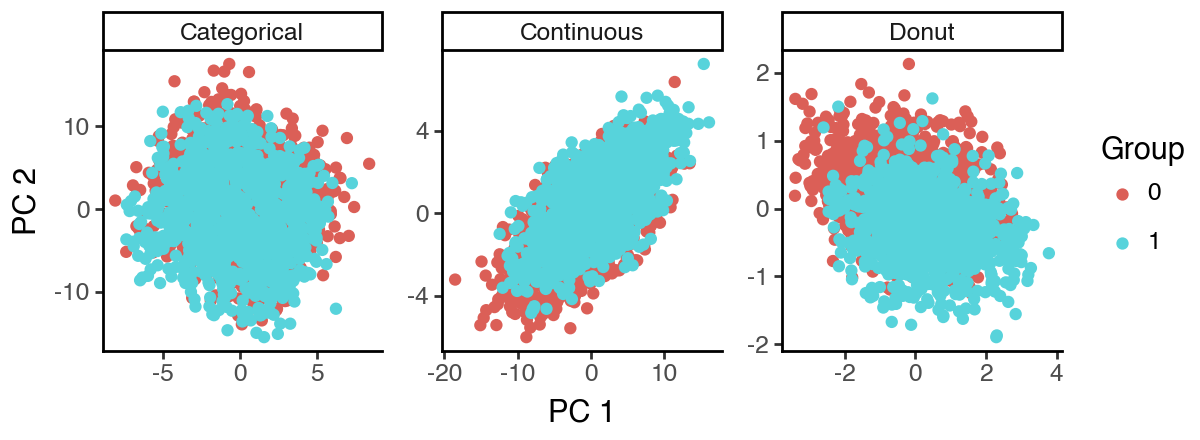

In [31]:
(
    ggplot(df_sispca, aes(x = 'dim_1', y = 'dim_2', color = 'cat')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Group') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

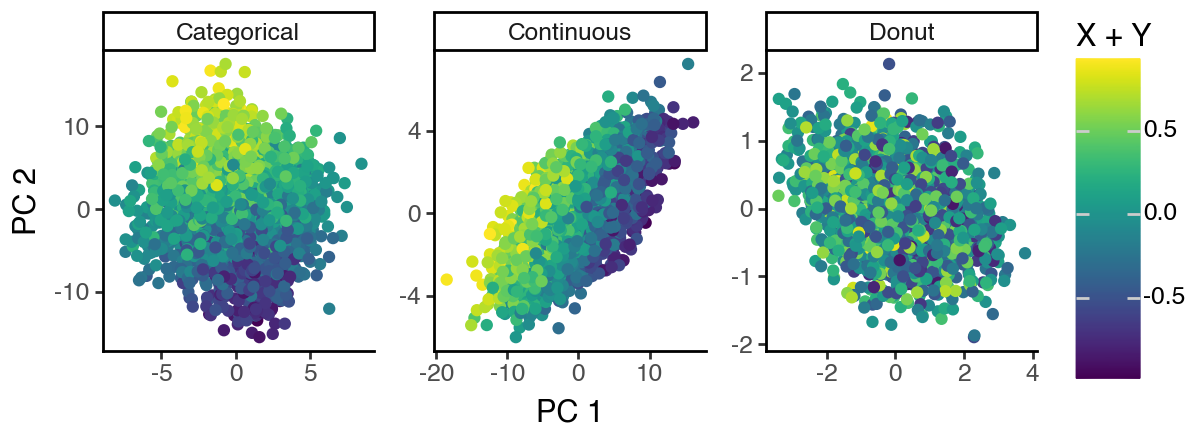

In [32]:
(
    ggplot(df_sispca, aes(x = 'dim_1', y = 'dim_2', color = 'cont')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'X + Y') +
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)

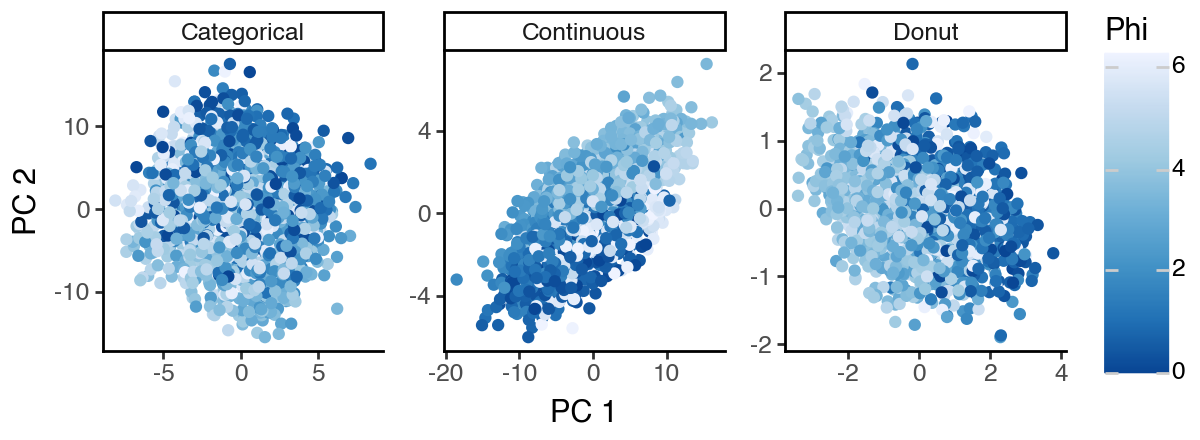

In [33]:
(
    ggplot(df_sispca, aes(x = 'dim_1', y = 'dim_2', color = 'phi')) +
        facet_wrap('~subspace', scales = 'free') +
        geom_point() +
        labs(x = 'PC 1', y = 'PC 2', color = 'Phi') +
        scale_color_distiller(palette = 1) + 
        theme_classic() + 
        theme(figure_size = (6, 2.2))
)